In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# Define the base image directory
base_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)/'

# Folder to score mapping
folder_score_map = {
    'Healthy': 10,
    'stripe_rust': 4,
    'septoria': 6
}

# Collect image paths and scores
data = []
for folder, score in folder_score_map.items():
    folder_path = os.path.join(base_dir, folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_path = os.path.join(folder, fname)
            data.append({'image_path': relative_path, 'score': score})

# Create dataframe
df = pd.DataFrame(data)

# Sort by filename
df = df.sort_values(by='image_path')

# Save to CSV
csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
df.to_csv(csv_path, index=False)

print(f"✅ CSV created with {len(df)} entries at: {csv_path}")


✅ CSV created with 407 entries at: /content/drive/MyDrive/arch/leaf_scores.csv


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        score = torch.tensor(row['score'], dtype=torch.float32)
        return image, score


In [ ]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform=transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
from torchvision import models
import torch.nn as nn

class ResNetRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

    def forward(self, x):
        return self.base_model(x).squeeze(1)


In [ ]:
import torch
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetRegressor().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, scores in train_loader:
        images, scores = images.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, scores in val_loader:
            images, scores = images.to(device), scores.to(device)
            outputs = model(images)
            loss = criterion(outputs, scores)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


Epoch 1, Train Loss: 24.6063, Val Loss: 13.9912
Epoch 2, Train Loss: 4.4542, Val Loss: 1.3892
Epoch 3, Train Loss: 0.8061, Val Loss: 1.1821
Epoch 4, Train Loss: 1.2751, Val Loss: 1.1717
Epoch 5, Train Loss: 0.6419, Val Loss: 0.4547


predictions on unseen data

In [ ]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
import torch
import os

def predict_leaf_health(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        score = output.item()
    return round(score, 2)


In [ ]:
# Update this path to your test image folder
unseen_folder = '/content/drive/MyDrive/arch/unseen_data'

predictions = []

for fname in os.listdir(unseen_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(unseen_folder, fname)
        predicted_score = predict_leaf_health(model, full_path, transform, device)
        predictions.append((fname, predicted_score))

# Display results
for fname, score in predictions:
    print(f"{fname:30s} ➜ Predicted Score: {score}")


Brown_rust009.jpg              ➜ Predicted Score: 5.07
Brown_rust029.jpg              ➜ Predicted Score: 6.37
Brown_rust040.jpg              ➜ Predicted Score: 5.77
Brown_rust007.jpg              ➜ Predicted Score: 5.78
Brown_rust018.jpg              ➜ Predicted Score: 5.51
Brown_rust025.jpg              ➜ Predicted Score: 6.23
Brown_rust023.jpg              ➜ Predicted Score: 6.16
Brown_rust016.jpg              ➜ Predicted Score: 7.22
Brown_rust001.jpg              ➜ Predicted Score: 6.06
Brown_rust038.jpg              ➜ Predicted Score: 4.97
Brown_rust005.jpg              ➜ Predicted Score: 5.08
Brown_rust004.jpg              ➜ Predicted Score: 5.68
Brown_rust006.jpg              ➜ Predicted Score: 6.01
Brown_rust015.jpg              ➜ Predicted Score: 6.14
Brown_rust010.jpg              ➜ Predicted Score: 5.85
Brown_rust024.jpg              ➜ Predicted Score: 7.37
Brown_rust021.jpg              ➜ Predicted Score: 4.54
Brown_rust030.jpg              ➜ Predicted Score: 5.85
Brown_rust

In [ ]:
import pandas as pd

df_preds = pd.DataFrame(predictions, columns=['image_name', 'predicted_score'])
df_preds.to_csv('/content/drive/MyDrive/arch/predicted_scores.csv', index=False)
print("✅ Saved predictions to predicted_scores.csv")


✅ Saved predictions to predicted_scores.csv


second approach classifier

In [ ]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Path to your image folders
data_path = '/content/drive/MyDrive/arch/wheat_leaf (1)'

# Load dataset with folder names as labels
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Split into train and val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Use ResNet18
model = models.resnet18(pretrained=True)

# Replace last layer for 3 classes
model.fc = nn.Linear(model.fc.in_features, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")


Epoch 1/5, Loss: 7.2806
Epoch 2/5, Loss: 1.1496
Epoch 3/5, Loss: 0.3546
Epoch 4/5, Loss: 0.2409
Epoch 5/5, Loss: 0.5203


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 98.78%


In [ ]:
import pandas as pd
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

# Put model in evaluation mode
model.eval()

# Load the full dataset again (with image paths)
full_dataset = ImageFolder(root=data_path, transform=transform)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# Reverse class mapping (e.g., 0: 'Healthy', 1: 'septoria', 2: 'stripe_rust')
class_to_label = {v: k for k, v in full_dataset.class_to_idx.items()}

# Prepare rows for CSV
csv_rows = []
image_idx = 0

with torch.no_grad():
    for inputs, _ in tqdm(full_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            img_path = full_dataset.samples[image_idx][0]
            folder, fname = img_path.split('/')[-2], img_path.split('/')[-1]
            pred_class = predicted[i].item()

            # Disease score mapping
            disease_score = {0: 10, 1: 3, 2: 2}[pred_class]

            # Estimated scores
            if pred_class == 0:  # Healthy
                appearance = 9.5
                growth = 9.0
                weed = 10.0
            elif pred_class == 1:  # Septoria
                appearance = 5.0
                growth = 6.0
                weed = 9.5
            else:  # Stripe Rust
                appearance = 4.5
                growth = 5.0
                weed = 8.0

            csv_rows.append({
                'filename': f"{folder}/{fname}",
                'class': pred_class,
                'disease': disease_score,
                'appearance': appearance,
                'growth': growth,
                'weed': weed
            })

            image_idx += 1

# Save the new CSV
output_csv = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
df = pd.DataFrame(csv_rows)
df.to_csv(output_csv, index=False)

print(f"✅ Auto-labeled CSV created at: {output_csv}")


100%|██████████| 13/13 [01:36<00:00,  7.39s/it]


✅ Auto-labeled CSV created at: /content/drive/MyDrive/arch/leaf_scores_auto.csv


Multi-Indicator Health Score Regression Model
We’ll build a model that takes a leaf image and predicts:

disease score

appearance score

growth score

weed score
All in the 1–10 range.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        scores = torch.tensor([
            row['disease'], row['appearance'],
            row['growth'], row['weed']
        ], dtype=torch.float32)
        return image, scores


In [ ]:
# Paths
csv_path = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf'



full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Updated dataset class that skips missing or unreadable images
class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            scores = torch.tensor([
                row['disease'], row['appearance'],
                row['growth'], row['weed']
            ], dtype=torch.float32)
            return image, scores

        except (FileNotFoundError, UnidentifiedImageError):
            return self.__getitem__((idx + 1) % len(self))

# Paths
csv_path = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)'

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
from sklearn.model_selection import train_test_split
import torch

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
import torch.nn as nn
import torchvision.models as models

class MultiIndicatorRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # Predict 4 health scores
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return torch.sigmoid(x) * 9 + 1  # Scale to 1–10 range

# Set up model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiIndicatorRegressor().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")


Epoch 1/5, Loss: 48.8717
Epoch 2/5, Loss: 14.5763
Epoch 3/5, Loss: 5.4515
Epoch 4/5, Loss: 2.3589
Epoch 5/5, Loss: 1.3277


In [ ]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()

print(f"Validation MSE: {val_loss:.4f}")


Validation MSE: 0.8966


GRADCAM to model

In [ ]:
# Store activations and gradients
feature_maps = None
gradients = None

def save_activation_hook(module, input, output):
    global feature_maps
    feature_maps = output.detach()

def save_gradient_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()


In [ ]:
# Hook into the last conv layer of ResNet18 (layer4)
last_conv_layer = model.backbone[-1]  # layer4 in resnet18
last_conv_layer.register_forward_hook(save_activation_hook)
last_conv_layer.register_backward_hook(save_gradient_hook)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def generate_gradcam(input_tensor, target_index):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    score = output[0, target_index]

    # Backward pass
    model.zero_grad()
    score.backward()

    # Compute GradCAM
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Global average pooling
    cam = torch.sum(weights * feature_maps, dim=1).squeeze()
    cam = torch.relu(cam)

    # Normalize
    cam -= cam.min()
    cam /= cam.max()

    # Resize to input size
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    # Convert to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    return heatmap


/tmp/ipython-input-27-1644188518.py:32: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


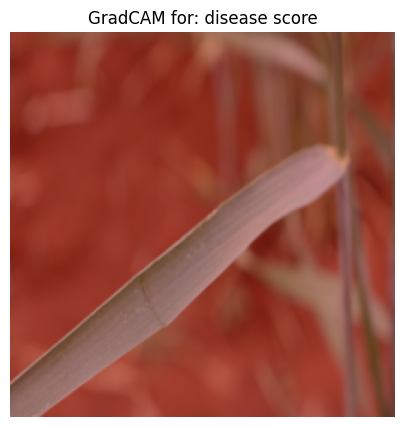

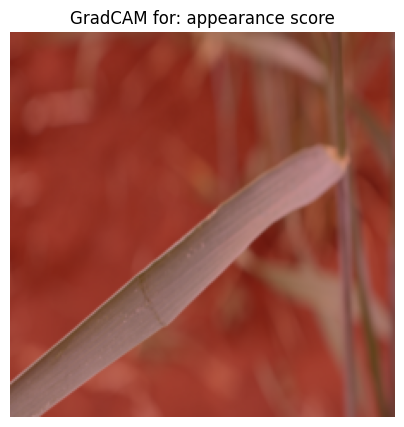

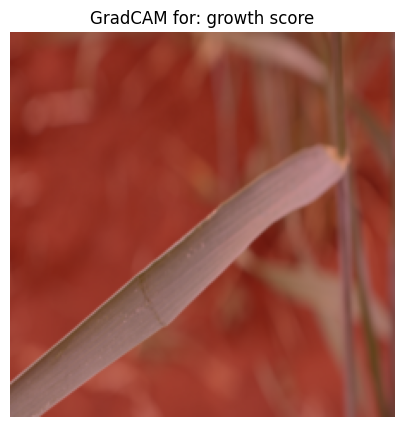

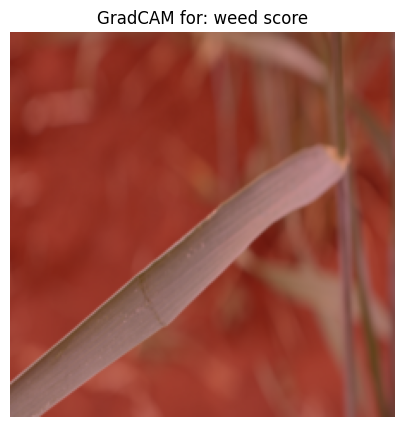

In [ ]:
# Load a sample image from your dataset
img, scores = full_dataset[0]  # Change index to test others
input_tensor = img.unsqueeze(0).to(device)

# Indicator names
indicators = ['disease', 'appearance', 'growth', 'weed']

# Generate and plot GradCAMs
for i in range(4):  # for each score
    heatmap = generate_gradcam(img, target_index=i)

    # Original image as numpy
    img_np = np.transpose(img.cpu().numpy(), (1, 2, 0))
    img_np = img_np / img_np.max()

    # Overlay heatmap
    overlay = 0.4 * heatmap + 0.6 * img_np
    overlay = np.clip(overlay, 0, 1)

    # Show it
    plt.figure(figsize=(5, 5))
    plt.title(f"GradCAM for: {indicators[i]} score")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()
